<a href="https://colab.research.google.com/github/jsm-UOC/tensorflowCourse/blob/main/FineTuningANNCourse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Fine Tuning in Tensorflow

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-05-04 11:04:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-04 11:04:54 (64.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get the data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-05-04 11:05:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.174.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.174.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  28.1MB/s    in 6.8s    

2023-05-04 11:05:07 (23.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
from tensorflow.python import train
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent, train_data_10_percent.class_names

(<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 ['chicken_curry',
  'chicken_wings',
  'fried_rice',
  'grilled_salmon',
  'hamburger',
  'ice_cream',
  'pizza',
  'ramen',
  'steak',
  'sushi'])

In [ ]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[ 29.428572    23.928572    49.714287  ]
   [ 34.72449     17.734694    44.734695  ]
   [ 64.37755     24.285715    58.19388   ]
   ...
   [ 41.785736    11.571472    14.214264  ]
   [ 44.010204    14.010206    14.010206  ]
   [ 45.44901     15.44901     13.44901   ]]

  [[  9.438776    24.938776    44.29592   ]
   [ 10.418367    17.82653     37.571426  ]
   [ 26.41837     17.67347     41.938774  ]
   ...
   [ 42.214306    12.000044    14.642836  ]
   [ 44.07144     14.071442    14.071442  ]
   [ 46.          16.          14.        ]]

  [[  6.0102034   28.602041    48.642857  ]
   [  1.3163265   25.397959    42.37755   ]
   [  3.1632667   21.571428    38.122448  ]
   ...
   [ 42.224495    11.448992    15.92855   ]
   [ 44.020412    14.0204115   15.448983  ]
   [ 45.285713    15.285714    14.714286  ]]

  ...

  [[119.         136.85712    164.57141   ]
   [120.37757    138.23468    165.94897   ]
   [121.92858    139.78569    167.49998   ]
   ...
   [126.         142.   

## Model 0: Building a feature extraction model using Keras Functional API


In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D through base model: {x.shape}")

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D through base model: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230504-111903
Epoch 1/5
24/24 [==============================] - 349s 14s/step - loss: 1.8839 - accuracy: 0.4040 - val_loss: 1.3194 - val_accuracy: 0.7108
Epoch 2/5
24/24 [==============================] - 264s 11s/step - loss: 1.1079 - accuracy: 0.7587 - val_loss: 0.8848 - val_accuracy: 0.8144
Epoch 3/5
24/24 [==============================] - 262s 11s/step - loss: 0.7932 - accuracy: 0.8253 - val_loss: 0.7074 - val_accuracy: 0.8452
Epoch 4/5
24/24 [==============================] - 262s 11s/step - loss: 0.6371 - accuracy: 0.8720 - val_loss: 0.6158 - val_accuracy: 0.8596
Epoch 5/5
24/24 [==============================] - 253s 11s/step - loss: 0.5430 - accuracy: 0.8840 - val_loss: 0.5627 - val_accuracy: 0.8648


In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

In [ ]:
base_model.summary()

In [ ]:
model_0.summary()

In [ ]:
plot_loss_curves(history_0)

## Getting a feature vector

In [ ]:
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}")

In [ ]:
tf.reduce_mean(input_tensor, axis=[1,2])

# Running a series of transfer learning models


## Preprocessing the data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2023-05-04 11:58:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M  31.0MB/s    in 5.1s    

2023-05-04 11:58:28 (25.2 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [ ]:
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
walk_through_dir("10_food_classes_1_percent")

In [ ]:
IMG_SIZE = (224, 224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=32)
test_data =  tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation

In [ ]:
print(tf.__version__)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.rescale(1./255)
], name="data_augmentation")


### Visualize Data Augmentation Layer

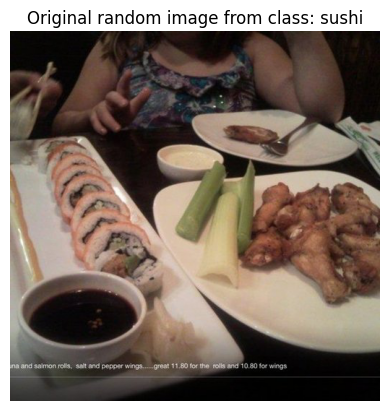

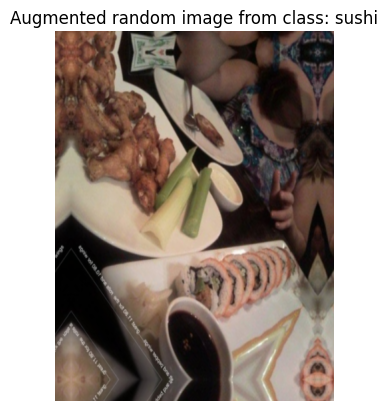

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir ="10_food_classes_1_percent/train/" + target_class

random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);


## Model 1: Feature Extraction with only 1% of the data

In [ ]:
input_shape = (224, 224,3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_1 = keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=0.25*len(test_data),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

In [ ]:
model_1.summary()

In [ ]:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

In [ ]:
plot_loss_curves(history_1_percent)

## Model 2: Feature Extraction with 10% of data augmented

In [ ]:
checkpoint_path = "10_porcent_model_checkpoints_weights/checkpoint.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_best_only=False,
                                                         save_weights_only=True,
                                                         save_freq="epoch",
                                                         verbose=1)

In [ ]:
input_shape = (224, 224,3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_2 = keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])


history_2 = model_2.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                experiment_name="10_percent_data_aug"),
                                    checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230504-115937
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9266 - accuracy: 0.3627
Epoch 1: saving model to 10_porcent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 159s 6s/step - loss: 1.9266 - accuracy: 0.3627 - val_loss: 1.4099 - val_accuracy: 0.6464
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2758 - accuracy: 0.6973
Epoch 2: saving model to 10_porcent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 169s 7s/step - loss: 1.2758 - accuracy: 0.6973 - val_loss: 0.9878 - val_accuracy: 0.7812
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9836 - accuracy: 0.7760
Epoch 3: saving model to 10_porcent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 145s 6s/step - loss: 0.9836 - accuracy: 0.7760 - val_loss: 0.7918 - val_accuracy: 0.8092
Epoch 4/5


In [ ]:
model_0.evaluate(test_data), model_2.evaluate(test_data)

In [ ]:
plot_loss_curves(history_2)

### Loading checkpointed witghts

In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_data) #0.8432000279426575 0.8676000237464905

### Model 3: Fine-tuning and existing model on 10% of the data

In [ ]:
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer, layer.trainable)

In [ ]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

In [ ]:
print(len(model_2.layers[2].trainable_variables))

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
print(len(model_2.layers[2].trainable_variables))

In [ ]:
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

history_fine_2 = model_2.fit(train_data_10_percent,
                        epochs=fine_tune_epochs,
                        initial_epoch=history_2.epoch[-1],
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230504-121626
Epoch 5/10
24/24 [==============================] - 161s 6s/step - loss: 0.5677 - accuracy: 0.8360 - val_loss: 0.4909 - val_accuracy: 0.8438
Epoch 6/10
24/24 [==============================] - 151s 6s/step - loss: 0.4567 - accuracy: 0.8653 - val_loss: 0.4657 - val_accuracy: 0.8454
Epoch 7/10
24/24 [==============================] - 162s 7s/step - loss: 0.4266 - accuracy: 0.8667 - val_loss: 0.4359 - val_accuracy: 0.8569
Epoch 8/10
24/24 [==============================] - 149s 6s/step - loss: 0.3617 - accuracy: 0.8933 - val_loss: 0.3979 - val_accuracy: 0.8684
Epoch 9/10
24/24 [==============================] - 171s 7s/step - loss: 0.3228 - accuracy: 0.8987 - val_loss: 0.3946 - val_accuracy: 0.8701
Epoch 10/10
24/24 [==============================] - 173s 7s/step - loss: 0.2948 - accuracy: 0.9307 - val_loss: 0.4038 - val_accuracy: 0.8717


In [ ]:
def compare_histories(original_history, new_history, initial_epochs=5):
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

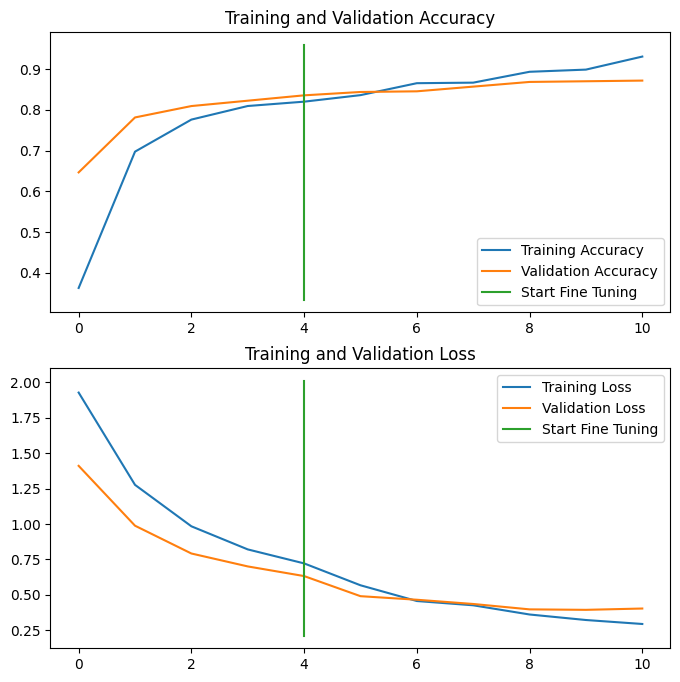

In [ ]:
compare_histories(original_history=history_2, new_history=history_fine_2, initial_epochs=5)

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2023-05-04 12:35:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  30.3MB/s    in 17s     

2023-05-04 12:35:45 (28.9 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
unzip_data("10_food_classes_all_data.zip")

In [ ]:
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data =  tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=32)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
base_model.trainable = False

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

model_2.load_weights(checkpoint_path)
model_2.evaluate(test_data)

79/79 [==============================] - 202s 2s/step - loss: 0.6193 - accuracy: 0.8416


[0.6193268895149231, 0.8416000008583069]

In [ ]:
for i, layer in enumerate(model_2.layers):
  print(i, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling2d True
4 output_layer True


In [ ]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_4 True
1 rescaling_6 True
2 normalization_3 True
3 rescaling_7 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn True
37 block2b_activation True
38 block2b_se_squeeze True
39 block2b_se_reshape True
40 block2b

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
for i, layer in enumerate(model_2.layers):
  print(i, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling2d True
4 output_layer True


In [ ]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_4 False
1 rescaling_6 False
2 normalization_3 False
3 rescaling_7 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

history_fine_2_full = model_2.fit(train_data_10_classes_full,
                        epochs=fine_tune_epochs,
                        initial_epoch=history_2.epoch[-1],
                        steps_per_epoch=len(train_data_10_classes_full),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                experiment_name="full_10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_percent_fine_tune_last_10/20230504-124523
Epoch 5/10
235/235 [==============================] - 805s 3s/step - loss: 0.6441 - accuracy: 0.7973 - val_loss: 0.3819 - val_accuracy: 0.8684
Epoch 6/10
235/235 [==============================] - 737s 3s/step - loss: 0.5188 - accuracy: 0.8276 - val_loss: 0.3453 - val_accuracy: 0.8849
Epoch 7/10
235/235 [==============================] - 738s 3s/step - loss: 0.4524 - accuracy: 0.8531 - val_loss: 0.2861 - val_accuracy: 0.9030
Epoch 8/10
235/235 [==============================] - 731s 3s/step - loss: 0.4135 - accuracy: 0.8675 - val_loss: 0.2791 - val_accuracy: 0.9095
Epoch 9/10
235/235 [==============================] - 728s 3s/step - loss: 0.3721 - accuracy: 0.8740 - val_loss: 0.3183 - val_accuracy: 0.8898
Epoch 10/10
235/235 [==============================] - 735s 3s/step - loss: 0.3474 - accuracy: 0.8853 - val_loss: 0.2737 - val_accuracy: 0.9128


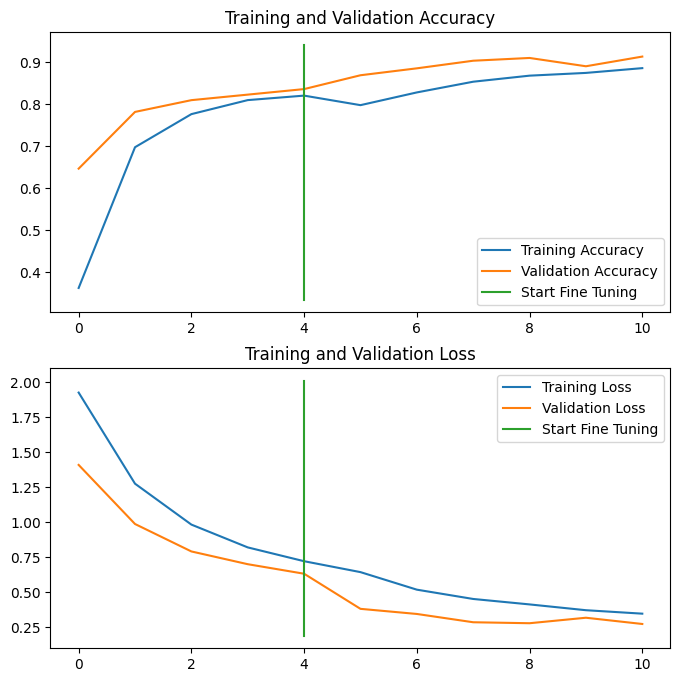

In [ ]:
compare_histories(original_history=history_2, new_history=history_fine_2_full, initial_epochs=5)

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 193s 2s/step - loss: 0.2673 - accuracy: 0.9160


[0.26725220680236816, 0.9160000085830688]

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes"\
  --description "A serioes of different experiments using Feature Extraction and Fine Tuning"\
  --one_shot

2023-05-04 14:13:35.147282: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   QDGN-NGVC



New experiment created. View your TensorBoard at: https://tensorboard.dev/ex